In [23]:
# Import necessary packages
import re
import os
import json
import pickle
import logging

logging.basicConfig(
    filename='info.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

from os.path import join
import numpy as np
import nltk
from nltk import bigrams
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torch.utils.data import Dataset, DataLoader
import transformers

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sleepyard\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sleepyard\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sleepyard\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
# Define test sets
trainset = 'twitter-training-data.txt'
devset = 'twitter-dev-data.txt'
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']
glove_file = 'glove.6B.100d.txt'

In [32]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]

            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'negative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    f1_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        f1_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            f1_by_class[gt]['tp'] += 1
        else:
            f1_by_class[gt]['fn'] += 1
            f1_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in f1_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1

        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + ')')
    avgrec = sum(float(acc['tp'] / (acc['tp'] + acc['fn'])) for _, acc in f1_by_class.items()) / 3
    print('Accuracy: %.3f,' % float(ok / len(id_gts)),
        'Average Recall: %.3f,' % avgrec,
        'Macro F1: %.3f' % semevalmacrof1
    )

In [33]:
# The preprocessor
def preprocess(tweet):
    # Remove RT (retweet)
    tweet = re.sub(r"\bRT\b", "", tweet)
    # Replace consecutive dots (...) with whitespace
    tweet = re.sub(r"[.\-']{2,}", " ", tweet)
    # Covert to lower case
    tweet = tweet.lower()
    # Remove URLs
    tweet = re.sub((r"((https?|ftp)://)?"
            r"[a-z0-9\-._~:/?#\[\]@!$&'()*+,;=%]+"
            r"\.[a-z]{2,}"
            r"[a-z0-9\-._~:/?#\[\]@!$&'()*+,;=%]*"
        ), "", tweet)
    # Remove user Mentions
    tweet = re.sub(r"@[\S]+", "", tweet)
    # Remove hashtags
    tweet = re.sub(r"#[\S]+", "", tweet)
    # Remove non-alphabet symbols (keep .'-:,)
    tweet = re.sub(r"[^a-z0-9.'\-:,/\s]", "", tweet)
    # Keep .'- if they are inside a word (between letters)
    tweet = re.sub(r"(?<![a-z])[.\-']|[.\-'](?![a-z])", " ", tweet)
    # Keep :, if thry are inside a number (between digits)
    tweet = re.sub(r"(?<![0-9])[:,/]|[:,/](?![0-9])", " ", tweet)
    # Replace multiple whitespaces with one
    tweet = re.sub(r"\s+", " ", tweet)
    # Remove whitespaces at the beginning or end
    tweet = tweet.strip()
    return tweet

In [34]:
# Load training set, dev set and testing set
tweetids = {}
tweetgts = {}
tweets = {}

for dataset in [trainset, devset] + testsets:
    tweets[dataset] = []
    tweetids[dataset] = []
    tweetgts[dataset] = []

    # write code to read in the datasets here
    dataset_path = join('semeval-tweets', dataset)
    with open(dataset_path, 'r', encoding='utf-8') as fh:
        for line in fh:
            fields = line.strip().split('\t')
            tweet_id = fields[0]
            sentiment = fields[1]
            tweet_text = preprocess(fields[2])

            tweetids[dataset].append(tweet_id)
            tweetgts[dataset].append(sentiment)
            tweets[dataset].append(tweet_text)

##### Support Vector Machine (SVM)

In [ ]:
# # Somehow took 7 hours to converge
# svm_linear_bow = SVC(kernel='linear')
# svm_linear_bow.fit(tweetbow[trainset], tweetgts[trainset])

SVC(kernel='linear')

In [ ]:
# # SVM with linear kernel on bag-of-word features
# id_preds = {}
# ids = tweetids[devset]
# preds = svm_linear_bow.predict(tweetbow[devset])
# for i in range(len(ids)):
#     id_preds[ids[i]] = preds[i]
            
# devset_name = devset
# devset_path = join('semeval-tweets', devset_name)
# confusion(id_preds, devset_path, "SVM")
# evaluate(id_preds, devset_path, "bow" + '-' + "Linear SVM")

            positive  negative  neutral
positive    0.695     0.044     0.261     
negative    0.106     0.598     0.296     
neutral     0.227     0.157     0.616     

semeval-tweets\twitter-dev-data.txt (bow-Linear SVM)
Accuracy: 0.637, Average Recall: 0.603, Macro F1: 0.588


In [ ]:
# # Took another 7 hours to run
# svm_poly_bow = SVC(kernel='poly')
# svm_poly_bow.fit(tweetbow[trainset], tweetgts[trainset])

SVC(kernel='poly')

In [ ]:
# # SVM with polynomial kernel on bag-of-word features
# id_preds = {}
# ids = tweetids[devset]
# preds = svm_poly_bow.predict(tweetbow[devset])
# for i in range(len(ids)):
#     id_preds[ids[i]] = preds[i]
            
# devset_name = devset
# devset_path = join('semeval-tweets', devset_name)
# confusion(id_preds, devset_path, "SVM")
# evaluate(id_preds, devset_path, "bow" + '-' + "Polynomial SVM")

            positive  negative  neutral
positive    0.745     0.034     0.221     
negative    0.146     0.625     0.229     
neutral     0.280     0.207     0.513     

semeval-tweets\twitter-dev-data.txt (bow-Polynomial SVM)
Accuracy: 0.553, Average Recall: 0.443, Macro F1: 0.304


In [ ]:
# # Takes more than 1000 iterations and 5.5 hours to run
# svm_rbf_bow = SVC(kernel='rbf')
# svm_rbf_bow.fit(tweetbow[trainset], tweetgts[trainset])

SVC()

In [ ]:
# # SVM with RBF kernel on bag-of-word features
# id_preds = {}
# ids = tweetids[devset]
# preds = svm_rbf_bow.predict(tweetbow[devset])
# for i in range(len(ids)):
#     id_preds[ids[i]] = preds[i]
            
# devset_name = devset
# devset_path = join('semeval-tweets', devset_name)
# confusion(id_preds, devset_path, "SVM")
# evaluate(id_preds, devset_path, "bow" + '-' + "RBF SVM")

            positive  negative  neutral
positive    0.755     0.035     0.210     
negative    0.114     0.705     0.181     
neutral     0.217     0.176     0.608     

semeval-tweets\twitter-dev-data.txt (bow-RBF SVM)
Accuracy: 0.656, Average Recall: 0.592, Macro F1: 0.565


In [ ]:
# The linear model is "good enough", the two non-linear ones could be overfitting
# But even the linear model is too slow to use: it takes too long to predict,
# for example, going through one dev/test set would take 5 minutes.
# Besides, the pickle file ended up to be larger than 1GB,
# so I decided to not use SVM for my final testing and not submit it

##### Transformer

In [60]:
transformer_name = "bert-base-uncased"
tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)
transformer = transformers.AutoModel.from_pretrained(transformer_name)

In [61]:
# Calculate the average length of raw tweet from each dataset
for dataset in [trainset, devset] + testsets:
    total_length = 0
    total_tweets = len(tweets[dataset])
    
    for tweet_raw in tweets[dataset]:
        total_length += len(tokenizer.tokenize(tweet_raw))
    
    average_length = total_length / total_tweets
    print(f"Average sentence length (raw) on {dataset}: {average_length}")

Average sentence length (raw) on twitter-training-data.txt: 20.248974523846478
Average sentence length (raw) on twitter-dev-data.txt: 20.1135
Average sentence length (raw) on twitter-test1.txt: 21.706881903143586
Average sentence length (raw) on twitter-test2.txt: 21.626011872638962
Average sentence length (raw) on twitter-test3.txt: 21.44766708701135


In [62]:
# The average length is around 20-21, let's see how many of the tweets are shorter than 40
# Most of the tweets are included here so we may just set max_length to 40
for dataset in [trainset, devset] + testsets:
    shorter_than = 0
    total_tweets = len(tweets[dataset])
    
    for tweet_raw in tweets[dataset]:
        if len(tokenizer.tokenize(tweet_raw)) <= 40:
            shorter_than += 1
    
    percentage = shorter_than / total_tweets
    print(f"{percentage} of tweets on {dataset} are shorter than 40 tokens")

0.9995787233099044 of tweets on twitter-training-data.txt are shorter than 40 tokens
0.999 of tweets on twitter-dev-data.txt are shorter than 40 tokens
0.9994335882186349 of tweets on twitter-test1.txt are shorter than 40 tokens
0.9994603345925526 of tweets on twitter-test2.txt are shorter than 40 tokens
1.0 of tweets on twitter-test3.txt are shorter than 40 tokens


In [63]:
# Customized Dataset reader FOR BERT
class CustomDatasetBERT(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.tweetgts = tweetgts[self.dataset]
        self.tweets = tweets[self.dataset]

    def __len__(self):
        return len(self.tweetgts)

    def __getitem__(self, idx):
        gts = self.tweetgts[idx]
        # Map labels to integer values
        if gts == 'neutral':
            label = torch.tensor(0)
        elif gts == 'negative':
            label = torch.tensor(1)
        elif gts == 'positive':
            label = torch.tensor(2)
        else:
            label = torch.tensor(0)
        # Pad the vector representation of tweets to length 40 with (index for) <pad>
        encoded_input = tokenizer(self.tweets[idx], padding='max_length', truncation=True, max_length=40)
        embed = torch.tensor(encoded_input['input_ids'], dtype=torch.int64)
        mask = torch.tensor(encoded_input['attention_mask'], dtype=torch.int64)
        return embed, mask, label

In [64]:
# Loading all the datasets
train_datasetBERT = CustomDatasetBERT(trainset)
dev_datasetBERT = CustomDatasetBERT(devset)

test_datasetsBERT = {}
for testset in testsets:
    test_datasetsBERT[testset] = CustomDatasetBERT(testset)

In [65]:
batch_sizeBERT = 32

train_loaderBERT = DataLoader(dataset=train_datasetBERT, batch_size=batch_sizeBERT, shuffle=True)
dev_loaderBERT = DataLoader(dataset=dev_datasetBERT, batch_size=batch_sizeBERT)

test_loadersBERT = {}
for testset in testsets:
    test_loadersBERT[testset] = DataLoader(dataset=test_datasetsBERT[testset], batch_size=batch_sizeBERT)

In [66]:
class SentimentTransformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, embed, mask):
        output = self.transformer(embed, attention_mask=mask, output_attentions=True)
        hidden = output.last_hidden_state
        attention = output.attentions[-1]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        return prediction

In [80]:
transformer_model = SentimentTransformer(transformer, 3, False)

In [68]:
count_parameters = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

print(f"The Transformer model has {count_parameters:,} trainable parameters")

The Transformer model has 109,484,547 trainable parameters


In [69]:
# Setting some parameters and choosing the optimzer, loss function, etc.
learning_rateBERT = 0.00001
optimizerBERT = optim.Adam(transformer_model.parameters(), lr=learning_rateBERT)
criterionBERT = nn.CrossEntropyLoss()
deviceBERT = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model = transformer_model.to(deviceBERT)
criterionBERT = criterionBERT.to(deviceBERT)

In [70]:
# Train the model
def train_modelBERT(model, criterion, optimizer, train_loader, epoch):
    model.train()
    train_loss = 0.0
    count = 0
    predictions = []
    true_labels = []
    total_step = len(train_loader)

    for i, (embeds, mask, labels) in enumerate(train_loader):
        embeds = embeds.to(deviceBERT)
        mask = mask.to(deviceBERT)
        labels = labels.to(deviceBERT)
        
        # Forward pass
        outputs = model(embeds, mask)
        loss = criterion(outputs, labels)

        predictions.extend(outputs.argmax(dim=-1).numpy())
        true_labels.extend(labels.numpy())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * embeds.size(0)
        count += embeds.size(0)
        
        if (i+1) % 100 == 0:
            logging.info('Epoch [{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, i+1, total_step, loss.item()))

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    macro_f1 = f1_score(true_labels, predictions, average='macro')

    average_loss = train_loss / count
    return average_loss, macro_f1

In [71]:
# Validate the model
def dev_modelBERT(model, criterion, dev_loader, epoch):
    model.eval()
    dev_loss = 0.0
    count = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for embeds, mask, labels in dev_loader:
            embeds = embeds.to(deviceBERT)
            mask = mask.to(deviceBERT)
            labels = labels.to(deviceBERT)
            outputs = model(embeds, mask)
            loss = criterion(outputs, labels)

            predictions.extend(outputs.argmax(dim=-1).numpy())
            true_labels.extend(labels.numpy())

            dev_loss += loss.item() * embeds.size(0)
            count += embeds.size(0)
    
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    macro_f1 = f1_score(true_labels, predictions, average='macro')

    average_loss = dev_loss / count
    return average_loss, macro_f1

In [72]:
def train_devBERT(model, criterion, optimizer, train_loader, dev_loader, num_epochs, path):
    torch.save(model.state_dict(), path)
    best_f1 = 0.0

    # loss across epochs
    train_loss_history = []
    dev_loss_history = []
    train_f1_history = []
    dev_f1_history = []

    for epoch in range(num_epochs):
        logging.info(f'Training epoch {epoch+1}......')
        train_loss, train_f1 = train_modelBERT(model, criterion, optimizer, train_loader, epoch)
        dev_loss, dev_f1 = dev_modelBERT(model, criterion, dev_loader, epoch)
        train_loss_history.append(train_loss)
        dev_loss_history.append(dev_loss)
        train_f1_history.append(train_f1)
        dev_f1_history.append(dev_f1)

        logging.info(f"Average training loss: {train_loss}; Macro F1: {train_f1}")
        logging.info(f"Average validation loss: {dev_loss}; Macro F1: {dev_f1}")
            
        # deep copy the model
        if dev_f1 > best_f1:
            best_f1 = dev_f1
            torch.save(model.state_dict(), path)

    # load best model weights
    model.load_state_dict(torch.load(path))

    return model, train_loss_history, dev_loss_history, train_f1_history, dev_f1_history

In [73]:
# Generate predictions
def test_modelBERT(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for embeds, mask, _ in test_loader:
            embeds = embeds.to(deviceBERT)
            mask = mask.to(deviceBERT)
            outputs = model(embeds, mask)
            for output in list(outputs.argmax(dim=-1)):
                if output == 0:
                    predictions.append('neutral')
                elif output == 1:
                    predictions.append('negative')
                elif output == 2:
                    predictions.append('positive')
                else:
                    predictions.append('neutral')

    return predictions

In [74]:
transformer_model, train_loss_BERT, dev_loss_BERT, train_f1_BERT, dev_f1_BERT = \
    train_devBERT(transformer_model, criterionBERT, optimizerBERT, train_loaderBERT, dev_loaderBERT, \
        5, 'transformer.pt')

In [57]:
# Loading the trained Transformer model (if not trained in the above cell)
transformer_model.load_state_dict(torch.load('transformer.pt'))

<All keys matched successfully>

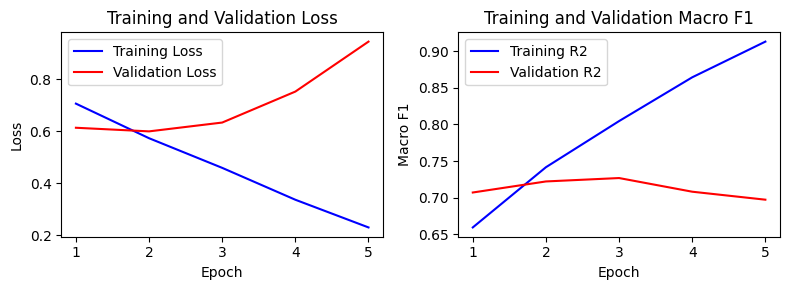

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(range(1, len(train_loss_BERT)+1), train_loss_BERT, color='blue', label='Training Loss')
axs[0].plot(range(1, len(dev_loss_BERT)+1), dev_loss_BERT, color='red', label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(range(1, len(train_f1_BERT)+1), train_f1_BERT, color='blue', label='Training R2')
axs[1].plot(range(1, len(dev_f1_BERT)+1), dev_f1_BERT, color='red', label='Validation R2')
axs[1].set_title('Training and Validation Macro F1')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Macro F1')
axs[1].legend()

plt.tight_layout()
plt.show()

In [77]:
id_preds = {}
ids = tweetids[devset]
preds = test_modelBERT(transformer_model, dev_loaderBERT)
for i in range(len(ids)):
    id_preds[ids[i]] = preds[i]
            
devset_name = devset
devset_path = join('semeval-tweets', devset_name)
confusion(id_preds, devset_path, "MaxEnt")
evaluate(id_preds, devset_path, "bow" + '-' + "MaxEnt")

            positive  negative  neutral
positive    0.758     0.016     0.227     
negative    0.033     0.711     0.256     
neutral     0.168     0.114     0.717     

semeval-tweets\twitter-dev-data.txt (bow-MaxEnt)
Accuracy: 0.731, Average Recall: 0.725, Macro F1: 0.730
